In [ ]:
from google.colab import drive
import zipfile, os

# Drive'ı bağla
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np

# Parametreler
SOURCE_DIR = '/content/drive/MyDrive/Ai_Human/Art'
DEST_DIR = '/content/drive/MyDrive/Ai_Human/Art_Split'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
BATCH_SIZE = 32
NUM_WORKERS = 2
RANDOM_SEED = 42

# Random seed ayarla
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# GPU kontrol
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1-2-3) Stratified split ve fiziksel klasör oluşturma
def create_stratified_split(source_dir, dest_dir, train_ratio, val_ratio, test_ratio):
    """Stratified split ile veriyi böl ve fiziksel klasörlere kaydet"""

    # Hedef klasörleri temizle ve oluştur
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    for split in ['train', 'val', 'test']:
        for class_name in ['AiArtData', 'RealArt']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    # Her sınıf için dosyaları topla ve böl
    for class_name in ['AiArtData', 'RealArt']:
        class_path = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # İlk split: train ve temp (val + test)
        train_files, temp_files = train_test_split(
            files,
            train_size=train_ratio,
            random_state=RANDOM_SEED
        )

        # İkinci split: val ve test
        val_files, test_files = train_test_split(
            temp_files,
            train_size=val_ratio/(val_ratio + test_ratio),
            random_state=RANDOM_SEED
        )

        # Dosyaları kopyala
        for file_name in train_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'train', class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in val_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'val', class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in test_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'test', class_name, file_name)
            shutil.copy2(src, dst)

        print(f'{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}')

create_stratified_split(SOURCE_DIR, DEST_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# 4) ImageNet normalization ve data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ImageFolder ile dataset oluştur
train_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'train'),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'val'),
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'test'),
    transform=val_test_transform
)

print(f'\nDataset sizes:')
print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')
print(f'Class to idx: {train_dataset.class_to_idx}')

# 5-6) GPU optimize DataLoader'lar
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

# 7-8) Transfer learning - Pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Son FC katmanını 2 sınıf için değiştir
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Modeli GPU'ya taşı
model = model.to(device)

print(f'\nModel loaded: ResNet18')
print(f'Modified FC layer: {num_features} -> 2')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

# Loss function ve optimizer tanımla (training loop için hazır)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print('\n✓ Setup complete! Ready for training.')

Using device: cuda
AiArtData: Train=377, Val=81, Test=81
RealArt: Train=305, Val=65, Test=66

Dataset sizes:
Train: 681
Val: 146
Test: 146
Class to idx: {'AiArtData': 0, 'RealArt': 1}
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 97.8MB/s]



Model loaded: ResNet18
Modified FC layer: 512 -> 2
Total parameters: 11,177,538
Trainable parameters: 11,177,538

✓ Setup complete! Ready for training.


Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6
AiArtData: Train=377, Val=81, Test=81
RealArt: Train=305, Val=65, Test=66

Dataset sizes:
Train: 681
Val: 146
Test: 146
Class to idx: {'AiArtData': 0, 'RealArt': 1}

Model loaded: ResNet18
Modified FC layer: 512 -> 2
Total parameters: 11,177,538
Trainable parameters: 11,177,538

✓ Setup complete! Starting training...


TRAINING STARTED

Epoch 1/20
------------------------------------------------------------


Training:   0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.9334 | Train Acc: 59.18%
Val Loss:   16.5845 | Val Acc:   44.52%
Model saved: /content/drive/MyDrive/Ai_Human/Models/best_model.pth
✓ New best model! Val Loss: 16.5845, Val Acc: 44.52%

Epoch 2/20
------------------------------------------------------------


Training:  32%|███▏      | 7/22 [00:10<00:20,  1.35s/it, loss=0.708, acc=60.3]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.6582 | Train Acc: 62.26%
Val Loss:   0.5149 | Val Acc:   68.49%
Model saved: /content/drive/MyDrive/Ai_Human/Models/best_model.pth
✓ New best model! Val Loss: 0.5149, Val Acc: 68.49%

Epoch 3/20
------------------------------------------------------------


Train Loss: 0.6208 | Train Acc: 67.40%
Val Loss:   0.6537 | Val Acc:   64.38%
No improvement for 1 epoch(s)

Epoch 4/20
------------------------------------------------------------


Train Loss: 0.6147 | Train Acc: 66.67%
Val Loss:   1.7991 | Val Acc:   41.78%
No improvement for 2 epoch(s)

Epoch 5/20
------------------------------------------------------------


Train Loss: 0.5927 | Train Acc: 69.16%
Val Loss:   0.5197 | Val Acc:   73.29%
No improvement for 3 epoch(s)
Model saved: /content/drive/MyDrive/Ai_Human/Models/checkpoint_epoch_5.pth

Epoch 6/20
------------------------------------------------------------


Train Loss: 0.6181 | Train Acc: 63.29%
Val Loss:   0.6180 | Val Acc:   67.81%
No improvement for 4 epoch(s)

Epoch 7/20
------------------------------------------------------------


Train Loss: 0.6188 | Train Acc: 64.76%
Val Loss:   0.5408 | Val Acc:   73.29%
No improvement for 5 epoch(s)

Early stopping triggered after 7 epochs

TRAINING COMPLETED
Total training time: 3.66 minutes
Best Val Loss: 0.5149
Best Val Acc: 68.49%

Training history plot saved: /content/drive/MyDrive/Ai_Human/Models/training_history.png


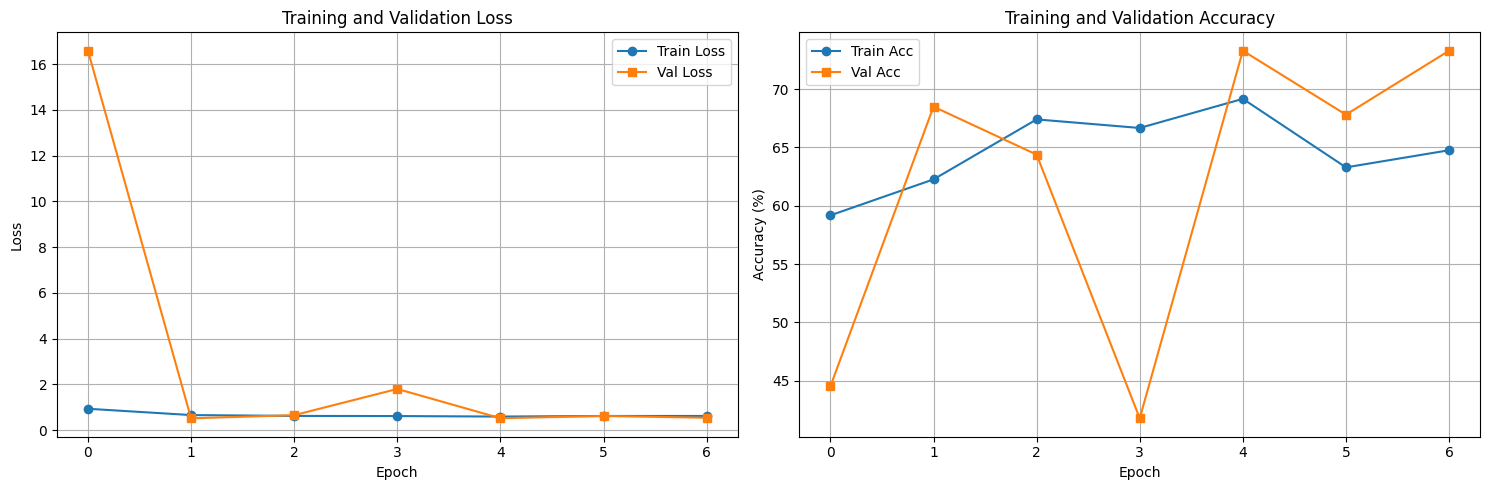


Loading best model for testing...


Testing: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


TEST RESULTS
Test Accuracy: 67.81%

Classification Report:
              precision    recall  f1-score   support

   AiArtData       0.66      0.85      0.75        81
     RealArt       0.71      0.46      0.56        65

    accuracy                           0.68       146
   macro avg       0.69      0.66      0.65       146
weighted avg       0.69      0.68      0.66       146

Confusion Matrix:
[[69 12]
 [35 30]]

ALL DONE!
Best model saved at: /content/drive/MyDrive/Ai_Human/Models
Final Test Accuracy: 67.81%


In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Parametreler
SOURCE_DIR = '/content/drive/MyDrive/Ai_Human/Art'
DEST_DIR = '/content/drive/MyDrive/Ai_Human/Art_Split'
MODEL_SAVE_DIR = '/content/drive/MyDrive/Ai_Human/Models'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
BATCH_SIZE = 32
NUM_WORKERS = 2
RANDOM_SEED = 42
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
PATIENCE = 5  # Early stopping

# Random seed ayarla
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# GPU kontrol
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'CUDA Version: {torch.version.cuda}')

# 1-2-3) Stratified split ve fiziksel klasör oluşturma
def create_stratified_split(source_dir, dest_dir, train_ratio, val_ratio, test_ratio):
    """Stratified split ile veriyi böl ve fiziksel klasörlere kaydet"""

    # Hedef klasörleri temizle ve oluştur
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    for split in ['train', 'val', 'test']:
        for class_name in ['AiArtData', 'RealArt']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    # Her sınıf için dosyaları topla ve böl
    for class_name in ['AiArtData', 'RealArt']:
        class_path = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # İlk split: train ve temp (val + test)
        train_files, temp_files = train_test_split(
            files,
            train_size=train_ratio,
            random_state=RANDOM_SEED
        )

        # İkinci split: val ve test
        val_files, test_files = train_test_split(
            temp_files,
            train_size=val_ratio/(val_ratio + test_ratio),
            random_state=RANDOM_SEED
        )

        # Dosyaları kopyala
        for file_name in train_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'train', class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in val_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'val', class_name, file_name)
            shutil.copy2(src, dst)

        for file_name in test_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(dest_dir, 'test', class_name, file_name)
            shutil.copy2(src, dst)

        print(f'{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}')

create_stratified_split(SOURCE_DIR, DEST_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# 4) ImageNet normalization ve data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ImageFolder ile dataset oluştur
train_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'train'),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'val'),
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'test'),
    transform=val_test_transform
)

print(f'\nDataset sizes:')
print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')
print(f'Class to idx: {train_dataset.class_to_idx}')

# 5-6) GPU optimize DataLoader'lar
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

# 7-8) Transfer learning - Pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Son FC katmanını 2 sınıf için değiştir
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Modeli GPU'ya taşı
model = model.to(device)

print(f'\nModel loaded: ResNet18')
print(f'Modified FC layer: {num_features} -> 2')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

# Loss function ve optimizer tanımla
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Model kaydetme klasörünü oluştur
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Training fonksiyonu
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Bir epoch için modeli eğit"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrikleri hesapla
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Progress bar güncelle
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

# Validation fonksiyonu
def validate(model, val_loader, criterion, device):
    """Modeli validation seti üzerinde değerlendir"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

# Test fonksiyonu (detaylı metriklerle)
def test_model(model, test_loader, device, class_names):
    """Modeli test seti üzerinde değerlendir ve detaylı metrikler üret"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrikleri hesapla
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    print('\n' + '='*60)
    print('TEST RESULTS')
    print('='*60)
    print(f'Test Accuracy: {accuracy:.2f}%\n')

    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    return accuracy, all_preds, all_labels

# Model kaydetme fonksiyonu
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, filename):
    """Model checkpoint'ini kaydet"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
    }
    torch.save(checkpoint, filename)
    print(f'Model saved: {filename}')

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, save_dir, patience=5):
    """Ana eğitim döngüsü"""

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_no_improve = 0

    print('\n' + '='*60)
    print('TRAINING STARTED')
    print('='*60)

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        # Training
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Learning rate scheduler
        scheduler.step(val_loss)

        # History kaydet
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Sonuçları yazdır
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')

        # En iyi modeli kaydet
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            epochs_no_improve = 0
            save_checkpoint(
                model, optimizer, epoch, val_loss, val_acc,
                os.path.join(save_dir, 'best_model.pth')
            )
            print(f'✓ New best model! Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epoch(s)')

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

        # Her 5 epoch'ta bir checkpoint kaydet
        if (epoch + 1) % 5 == 0:
            save_checkpoint(
                model, optimizer, epoch, val_loss, val_acc,
                os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth')
            )

    training_time = time.time() - start_time

    print('\n' + '='*60)
    print('TRAINING COMPLETED')
    print('='*60)
    print(f'Total training time: {training_time/60:.2f} minutes')
    print(f'Best Val Loss: {best_val_loss:.4f}')
    print(f'Best Val Acc: {best_val_acc:.2f}%')

    return history

# Grafik çizme fonksiyonu
def plot_training_history(history, save_path):
    """Eğitim geçmişini görselleştir"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss grafiği
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy grafiği
    ax2.plot(history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(history['val_acc'], label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'\nTraining history plot saved: {save_path}')
    plt.show()

# Eğitimi başlat
print('\n✓ Setup complete! Starting training...\n')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_dir=MODEL_SAVE_DIR,
    patience=PATIENCE
)

# Training history grafiğini kaydet
plot_training_history(history, os.path.join(MODEL_SAVE_DIR, 'training_history.png'))

# En iyi modeli yükle ve test et
print('\nLoading best model for testing...')
checkpoint = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Test sonuçları
class_names = list(train_dataset.class_to_idx.keys())
test_accuracy, test_preds, test_labels = test_model(model, test_loader, device, class_names)

print('\n' + '='*60)
print('ALL DONE!')
print('='*60)
print(f'Best model saved at: {MODEL_SAVE_DIR}')
print(f'Final Test Accuracy: {test_accuracy:.2f}%')


Using device: cuda
GPU: Tesla T4
AiArtData: Train=377, Val=81, Test=81
RealArt: Train=305, Val=65, Test=66

Dataset sizes:
Train: 681
Val: 146
Test: 146
Class distribution: {'AiArtData': 0, 'RealArt': 1}

BUILDING IMPROVED MODEL
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


Model: ResNet50 with custom classifier
Total parameters: 24,033,090
Trainable parameters: 15,489,794

Class weights: tensor([0.0027, 0.0033], device='cuda:0')

✓ Setup complete! Starting improved training...


TRAINING STARTED

Epoch 1/30
------------------------------------------------------------
Learning Rate: 0.000100


Training:  21%|██        | 9/43 [00:09<00:29,  1.16it/s, loss=0.715, acc=52.8]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  70%|██████▉   | 30/43 [00:22<00:08,  1.62it/s, loss=0.624, acc=55.8]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.6699 | Train Acc: 56.53%
Val Loss:   0.6322 | Val Acc:   73.29%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.6322, Val Acc: 73.29%

Epoch 2/30
------------------------------------------------------------
Learning Rate: 0.000098


Train Loss: 0.5777 | Train Acc: 67.69%
Val Loss:   0.5448 | Val Acc:   73.97%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.5448, Val Acc: 73.97%

Epoch 3/30
------------------------------------------------------------
Learning Rate: 0.000091


Train Loss: 0.4841 | Train Acc: 68.58%
Val Loss:   0.5416 | Val Acc:   70.55%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.5416, Val Acc: 70.55%

Epoch 4/30
------------------------------------------------------------
Learning Rate: 0.000080


Train Loss: 0.4124 | Train Acc: 76.06%
Val Loss:   0.4175 | Val Acc:   80.82%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.4175, Val Acc: 80.82%

Epoch 5/30
------------------------------------------------------------
Learning Rate: 0.000066


Train Loss: 0.3844 | Train Acc: 73.27%
Val Loss:   0.4369 | Val Acc:   82.88%
No improvement for 1 epoch(s)

Epoch 6/30
------------------------------------------------------------
Learning Rate: 0.000051


Train Loss: 0.3501 | Train Acc: 80.47%
Val Loss:   0.4161 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.4161, Val Acc: 84.93%

Epoch 7/30
------------------------------------------------------------
Learning Rate: 0.000035


Train Loss: 0.2921 | Train Acc: 82.38%
Val Loss:   0.3849 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.3849, Val Acc: 84.93%

Epoch 8/30
------------------------------------------------------------
Learning Rate: 0.000021


Train Loss: 0.2829 | Train Acc: 81.20%
Val Loss:   0.3793 | Val Acc:   84.25%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.3793, Val Acc: 84.25%

Epoch 9/30
------------------------------------------------------------
Learning Rate: 0.000010


Train Loss: 0.2922 | Train Acc: 80.91%
Val Loss:   0.3689 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Loss: 0.3689, Val Acc: 84.93%

Epoch 10/30
------------------------------------------------------------
Learning Rate: 0.000003


Train Loss: 0.2589 | Train Acc: 81.79%
Val Loss:   0.3768 | Val Acc:   84.93%
No improvement for 1 epoch(s)

Epoch 11/30
------------------------------------------------------------
Learning Rate: 0.000100


Train Loss: 0.2935 | Train Acc: 79.00%
Val Loss:   0.4074 | Val Acc:   84.93%
No improvement for 2 epoch(s)

Epoch 12/30
------------------------------------------------------------
Learning Rate: 0.000099


Train Loss: 0.2687 | Train Acc: 81.94%
Val Loss:   0.4932 | Val Acc:   80.14%
No improvement for 3 epoch(s)

Epoch 13/30
------------------------------------------------------------
Learning Rate: 0.000098


Train Loss: 0.2972 | Train Acc: 80.32%
Val Loss:   0.4006 | Val Acc:   84.25%
No improvement for 4 epoch(s)

Epoch 14/30
------------------------------------------------------------
Learning Rate: 0.000095


Train Loss: 0.2183 | Train Acc: 79.88%
Val Loss:   0.4896 | Val Acc:   83.56%
No improvement for 5 epoch(s)

Epoch 15/30
------------------------------------------------------------
Learning Rate: 0.000091


Train Loss: 0.1851 | Train Acc: 85.90%
Val Loss:   0.5617 | Val Acc:   83.56%
No improvement for 6 epoch(s)

Epoch 16/30
------------------------------------------------------------
Learning Rate: 0.000086


Train Loss: 0.2048 | Train Acc: 83.85%
Val Loss:   0.4485 | Val Acc:   82.19%
No improvement for 7 epoch(s)

Early stopping triggered after 16 epochs

TRAINING COMPLETED
Total training time: 8.99 minutes
Best Val Loss: 0.3689
Best Val Acc: 84.93%

Training history plot saved: /content/drive/MyDrive/Ai_Human/Models_V2/training_history_v2.png


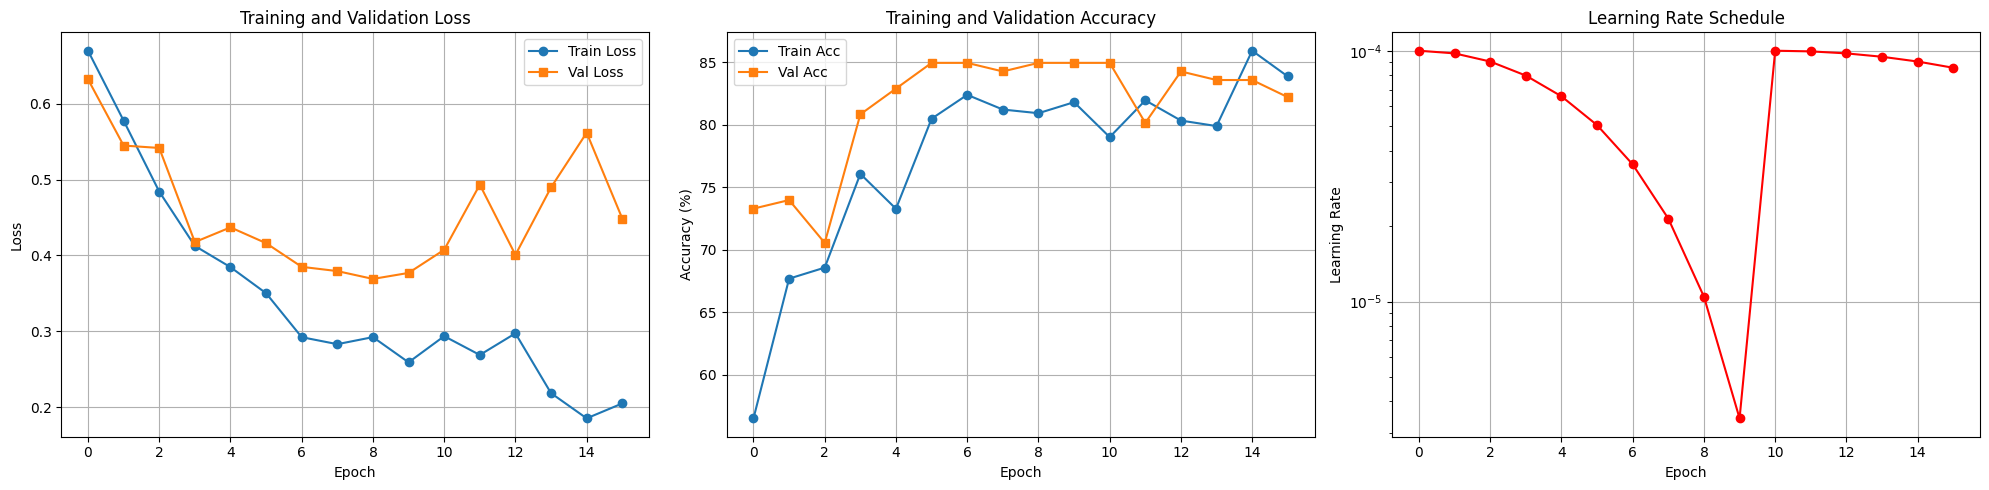


Loading best model for testing...


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


TEST RESULTS
Test Accuracy: 79.45%

Classification Report:
              precision    recall  f1-score   support

   AiArtData       0.87      0.74      0.80        81
     RealArt       0.73      0.86      0.79        65

    accuracy                           0.79       146
   macro avg       0.80      0.80      0.79       146
weighted avg       0.81      0.79      0.79       146

Confusion Matrix:
[[60 21]
 [ 9 56]]

IMPROVED MODEL COMPLETE!
Best model saved at: /content/drive/MyDrive/Ai_Human/Models_V2
Final Test Accuracy: 79.45%


In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# IMPROVED PARAMETRELER
SOURCE_DIR = '/content/drive/MyDrive/Ai_Human/Art'
DEST_DIR = '/content/drive/MyDrive/Ai_Human/Art_Split'
MODEL_SAVE_DIR = '/content/drive/MyDrive/Ai_Human/Models_V2'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
BATCH_SIZE = 16  # Daha küçük batch size -> daha iyi generalization
NUM_WORKERS = 2
RANDOM_SEED = 42
NUM_EPOCHS = 30  # Daha fazla epoch
LEARNING_RATE = 0.0001  # Daha düşük LR
WEIGHT_DECAY = 1e-4  # L2 regularization
PATIENCE = 7

# Random seed
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

# Stratified split (aynı)
def create_stratified_split(source_dir, dest_dir, train_ratio, val_ratio, test_ratio):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    for split in ['train', 'val', 'test']:
        for class_name in ['AiArtData', 'RealArt']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    for class_name in ['AiArtData', 'RealArt']:
        class_path = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        train_files, temp_files = train_test_split(
            files, train_size=train_ratio, random_state=RANDOM_SEED
        )
        val_files, test_files = train_test_split(
            temp_files, train_size=val_ratio/(val_ratio + test_ratio), random_state=RANDOM_SEED
        )

        for file_name in train_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'train', class_name, file_name))
        for file_name in val_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'val', class_name, file_name))
        for file_name in test_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'test', class_name, file_name))

        print(f'{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}')

create_stratified_split(SOURCE_DIR, DEST_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# IMPROVED DATA AUGMENTATION - Daha agresif
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Daha agresif crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # Yeni
    transforms.RandomRotation(20),  # Daha fazla rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Daha agresif
    transforms.RandomGrayscale(p=0.1),  # Yeni - bazen grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))  # Yeni - random erasing
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'train'),
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'val'),
    transform=val_test_transform
)
test_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'test'),
    transform=val_test_transform
)

print(f'\nDataset sizes:')
print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')
print(f'Class distribution: {train_dataset.class_to_idx}')

# CLASS IMBALANCE - Weighted Sampler
def get_weighted_sampler(dataset):
    """Class imbalance için weighted sampling"""
    targets = [s[1] for s in dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

train_sampler = get_weighted_sampler(train_dataset)

# DataLoader with weighted sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,  # shuffle yerine sampler
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

# IMPROVED MODEL - ResNet50 (daha güçlü)
print('\n' + '='*60)
print('BUILDING IMPROVED MODEL')
print('='*60)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # V2 weights daha iyi

# Feature extraction için ilk katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Sadece son birkaç bloğu fine-tune et
for param in model.layer4.parameters():
    param.requires_grad = True

# Dropout ekle ve yeni classifier
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

model = model.to(device)

print(f'Model: ResNet50 with custom classifier')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

# IMPROVED LOSS - Weighted CrossEntropyLoss
targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = torch.FloatTensor(1.0 / class_counts).to(device)
print(f'\nClass weights: {class_weights}')

criterion = nn.CrossEntropyLoss(weight=class_weights)

# IMPROVED OPTIMIZER - AdamW with weight decay
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler - Cosine Annealing with Warm Restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# MIXUP Augmentation
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training with Mixup
def train_one_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_mixup and np.random.rand() > 0.5:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.2)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def test_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    print('\n' + '='*60)
    print('TEST RESULTS')
    print('='*60)
    print(f'Test Accuracy: {accuracy:.2f}%\n')

    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print('Confusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    return accuracy, all_preds, all_labels

def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
    }
    torch.save(checkpoint, filename)
    print(f'Model saved: {filename}')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, save_dir, patience=7):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_no_improve = 0

    print('\n' + '='*60)
    print('TRAINING STARTED')
    print('='*60)

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            epochs_no_improve = 0
            save_checkpoint(
                model, optimizer, epoch, val_loss, val_acc,
                os.path.join(save_dir, 'best_model.pth')
            )
            print(f'✓ New best model! Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epoch(s)')

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

    training_time = time.time() - start_time

    print('\n' + '='*60)
    print('TRAINING COMPLETED')
    print('='*60)
    print(f'Total training time: {training_time/60:.2f} minutes')
    print(f'Best Val Loss: {best_val_loss:.4f}')
    print(f'Best Val Acc: {best_val_acc:.2f}%')

    return history

def plot_training_history(history, save_path):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Learning Rate
    axes[2].plot(history['lr'], marker='o', color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_yscale('log')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'\nTraining history plot saved: {save_path}')
    plt.show()

# BAŞLAT
print('\n✓ Setup complete! Starting improved training...\n')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_dir=MODEL_SAVE_DIR,
    patience=PATIENCE
)

plot_training_history(history, os.path.join(MODEL_SAVE_DIR, 'training_history_v2.png'))

print('\nLoading best model for testing...')
checkpoint = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

class_names = list(train_dataset.class_to_idx.keys())
test_accuracy, test_preds, test_labels = test_model(model, test_loader, device, class_names)

print('\n' + '='*60)
print('IMPROVED MODEL COMPLETE!')
print('='*60)
print(f'Best model saved at: {MODEL_SAVE_DIR}')
print(f'Final Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# IMPROVED PARAMETRELER
SOURCE_DIR = '/content/drive/MyDrive/Ai_Human/Art'
DEST_DIR = '/content/drive/MyDrive/Ai_Human/Art_Split'
MODEL_SAVE_DIR = '/content/drive/MyDrive/Ai_Human/Models_V2'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
BATCH_SIZE = 16  # Daha küçük batch size -> daha iyi generalization
NUM_WORKERS = 2
RANDOM_SEED = 42
NUM_EPOCHS = 30  # Daha fazla epoch
LEARNING_RATE = 0.0001  # Daha düşük LR
WEIGHT_DECAY = 1e-4  # L2 regularization
PATIENCE = 7

# Random seed
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

# Stratified split (aynı)
def create_stratified_split(source_dir, dest_dir, train_ratio, val_ratio, test_ratio):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    for split in ['train', 'val', 'test']:
        for class_name in ['AiArtData', 'RealArt']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    for class_name in ['AiArtData', 'RealArt']:
        class_path = os.path.join(source_dir, class_name)
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        train_files, temp_files = train_test_split(
            files, train_size=train_ratio, random_state=RANDOM_SEED
        )
        val_files, test_files = train_test_split(
            temp_files, train_size=val_ratio/(val_ratio + test_ratio), random_state=RANDOM_SEED
        )

        for file_name in train_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'train', class_name, file_name))
        for file_name in val_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'val', class_name, file_name))
        for file_name in test_files:
            shutil.copy2(os.path.join(class_path, file_name),
                        os.path.join(dest_dir, 'test', class_name, file_name))

        print(f'{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}')

create_stratified_split(SOURCE_DIR, DEST_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# IMPROVED DATA AUGMENTATION - Daha agresif
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Daha agresif crop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # Yeni
    transforms.RandomRotation(20),  # Daha fazla rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Daha agresif
    transforms.RandomGrayscale(p=0.1),  # Yeni - bazen grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))  # Yeni - random erasing
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'train'),
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'val'),
    transform=val_test_transform
)
test_dataset = datasets.ImageFolder(
    root=os.path.join(DEST_DIR, 'test'),
    transform=val_test_transform
)

print(f'\nDataset sizes:')
print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')
print(f'Class distribution: {train_dataset.class_to_idx}')

# CLASS IMBALANCE - Weighted Sampler
def get_weighted_sampler(dataset):
    """Class imbalance için weighted sampling"""
    targets = [s[1] for s in dataset.samples]
    class_counts = np.bincount(targets)
    class_weights = 1. / class_counts
    sample_weights = [class_weights[t] for t in targets]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

train_sampler = get_weighted_sampler(train_dataset)

# DataLoader with weighted sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,  # shuffle yerine sampler
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

# IMPROVED MODEL - ResNet50 (daha güçlü)
print('\n' + '='*60)
print('BUILDING IMPROVED MODEL')
print('='*60)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # V2 weights daha iyi

# Feature extraction için ilk katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Sadece son birkaç bloğu fine-tune et
for param in model.layer4.parameters():
    param.requires_grad = True

# Dropout ekle ve yeni classifier
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

model = model.to(device)

print(f'Model: ResNet50 with custom classifier')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

# IMPROVED LOSS - Weighted CrossEntropyLoss
targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = torch.FloatTensor(1.0 / class_counts).to(device)
print(f'\nClass weights: {class_weights}')

criterion = nn.CrossEntropyLoss(weight=class_weights)

# IMPROVED OPTIMIZER - AdamW with weight decay
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler - Cosine Annealing with Warm Restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# MIXUP Augmentation
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Training with Mixup
def train_one_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if use_mixup and np.random.rand() > 0.5:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.2)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def test_model(model, test_loader, device, class_names):
    """Test model and return detailed results including sample images"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_images = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Testing')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_images.extend(inputs.cpu())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = 100 * np.mean(all_preds == all_labels)

    print('\n' + '='*60)
    print('TEST RESULTS')
    print('='*60)
    print(f'Test Accuracy: {accuracy:.2f}%\n')

    print('Classification Report:')
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Per-class metrics
    print('\nPer-Class Detailed Metrics:')
    print('-' * 60)
    for class_name in class_names:
        metrics = report[class_name]
        print(f'{class_name}:')
        print(f'  Precision: {metrics["precision"]:.4f}')
        print(f'  Recall:    {metrics["recall"]:.4f}')
        print(f'  F1-Score:  {metrics["f1-score"]:.4f}')
        print(f'  Support:   {int(metrics["support"])}')
        print()

    # Overall metrics
    print('Overall Metrics:')
    print(f'  Macro Avg Precision: {report["macro avg"]["precision"]:.4f}')
    print(f'  Macro Avg Recall:    {report["macro avg"]["recall"]:.4f}')
    print(f'  Macro Avg F1-Score:  {report["macro avg"]["f1-score"]:.4f}')
    print(f'  Weighted Avg F1:     {report["weighted avg"]["f1-score"]:.4f}')

    print('\nConfusion Matrix:')
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Calculate per-class accuracy
    print('\nPer-Class Accuracy:')
    for i, class_name in enumerate(class_names):
        class_acc = 100 * cm[i, i] / cm[i].sum()
        print(f'{class_name}: {class_acc:.2f}%')

    return accuracy, all_preds, all_labels, all_probs, all_images, cm

def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'val_acc': val_acc,
    }
    torch.save(checkpoint, filename)
    print(f'Model saved: {filename}')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, save_dir, patience=7):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_combined_score = 0.0  # Yeni: loss ve accuracy'yi birlikte değerlendir
    epochs_no_improve = 0

    print('\n' + '='*60)
    print('TRAINING STARTED')
    print('='*60)

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')

        # Combined score: normalize loss ve accuracy'yi birleştir
        # Lower loss is better, higher accuracy is better
        # Combined score = accuracy - normalized_loss
        normalized_loss = val_loss / (train_loss + 1e-8)  # Relative to train loss
        combined_score = val_acc - (normalized_loss * 10)  # Weight loss component

        improved = False

        # Primary criterion: validation accuracy (daha önemli)
        # Secondary criterion: validation loss (eşit accuracy'de karar verici)
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_combined_score = combined_score
            epochs_no_improve = 0
            improved = True

        if improved:
            save_checkpoint(
                model, optimizer, epoch, val_loss, val_acc,
                os.path.join(save_dir, 'best_model.pth')
            )
            print(f'✓ New best model! Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epoch(s)')

        if epochs_no_improve >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

    training_time = time.time() - start_time

    print('\n' + '='*60)
    print('TRAINING COMPLETED')
    print('='*60)
    print(f'Total training time: {training_time/60:.2f} minutes')
    print(f'Best Val Loss: {best_val_loss:.4f}')
    print(f'Best Val Acc: {best_val_acc:.2f}%')

    return history

def plot_training_history(history, save_path):
    """Plot training history with loss, accuracy, and learning rate"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Learning Rate
    axes[2].plot(history['lr'], marker='o', color='red', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'\n✓ Training history plot saved: {save_path}')
    plt.close()

def plot_confusion_matrix(cm, class_names, save_path):
    """Plot confusion matrix as heatmap"""
    plt.figure(figsize=(10, 8))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create annotations with both counts and percentages
    annotations = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_normalized[i, j] * 100
            annotations[i, j] = f'{count}\n({percentage:.1f}%)'

    sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count'}, vmin=0, vmax=1)

    plt.title('Confusion Matrix\n(Normalized with Counts)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'✓ Confusion matrix plot saved: {save_path}')
    plt.close()

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def plot_sample_predictions(images, labels, predictions, probs, class_names, save_path, num_samples=12):
    """Plot sample predictions with images"""
    # Select random samples
    num_samples = min(num_samples, len(images))
    indices = np.random.choice(len(images), num_samples, replace=False)

    # Create figure with subplots
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for idx, sample_idx in enumerate(indices):
        img = images[sample_idx]
        true_label = labels[sample_idx]
        pred_label = predictions[sample_idx]
        prob = probs[sample_idx]

        # Denormalize image
        img_denorm = denormalize(img)
        img_np = img_denorm.permute(1, 2, 0).numpy()

        # Plot image
        axes[idx].imshow(img_np)
        axes[idx].axis('off')

        # Create title with prediction info
        true_class = class_names[true_label]
        pred_class = class_names[pred_label]
        confidence = prob[pred_label] * 100

        # Color: green if correct, red if wrong
        color = 'green' if true_label == pred_label else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)

    plt.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'✓ Sample predictions plot saved: {save_path}')
    plt.close()

def plot_error_analysis(images, labels, predictions, probs, class_names, save_path, num_samples=8):
    """Plot misclassified samples for error analysis"""
    # Find misclassified samples
    misclassified_indices = np.where(np.array(labels) != np.array(predictions))[0]

    if len(misclassified_indices) == 0:
        print('✓ No misclassified samples found!')
        return

    # Select random misclassified samples
    num_samples = min(num_samples, len(misclassified_indices))
    indices = np.random.choice(misclassified_indices, num_samples, replace=False)

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for idx, sample_idx in enumerate(indices):
        img = images[sample_idx]
        true_label = labels[sample_idx]
        pred_label = predictions[sample_idx]
        prob = probs[sample_idx]

        # Denormalize image
        img_denorm = denormalize(img)
        img_np = img_denorm.permute(1, 2, 0).numpy()

        # Plot image
        axes[idx].imshow(img_np)
        axes[idx].axis('off')

        # Create title
        true_class = class_names[true_label]
        pred_class = class_names[pred_label]
        confidence = prob[pred_label] * 100

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color='red')

    plt.suptitle('Error Analysis - Misclassified Samples', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f'✓ Error analysis plot saved: {save_path}')
    plt.close()

# BAŞLAT
print('\n✓ Setup complete! Starting improved training...\n')

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    save_dir=MODEL_SAVE_DIR,
    patience=PATIENCE
)

# Plot training history
plot_training_history(history, os.path.join(MODEL_SAVE_DIR, 'training_history_v2.png'))

# Load best model for testing
print('\nLoading best model for testing...')
checkpoint = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f'Loaded model from epoch {checkpoint["epoch"]+1}')
print(f'  - Validation Loss: {checkpoint["val_loss"]:.4f}')
print(f'  - Validation Accuracy: {checkpoint["val_acc"]:.2f}%')

# Test model
class_names = list(train_dataset.class_to_idx.keys())
test_accuracy, test_preds, test_labels, test_probs, test_images, cm = test_model(
    model, test_loader, device, class_names
)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names, os.path.join(MODEL_SAVE_DIR, 'confusion_matrix_v2.png'))

# Plot sample predictions
plot_sample_predictions(
    test_images, test_labels, test_preds, test_probs, class_names,
    os.path.join(MODEL_SAVE_DIR, 'sample_predictions_v2.png'),
    num_samples=12
)

# Plot error analysis (misclassified samples)
plot_error_analysis(
    test_images, test_labels, test_preds, test_probs, class_names,
    os.path.join(MODEL_SAVE_DIR, 'error_analysis_v2.png'),
    num_samples=8
)

print('\n' + '='*60)
print('IMPROVED MODEL COMPLETE!')
print('='*60)
print(f'Best model saved at: {MODEL_SAVE_DIR}')
print(f'Final Test Accuracy: {test_accuracy:.2f}%')
print(f'\nGenerated visualizations:')
print(f'  1. Training History: training_history_v2.png')
print(f'  2. Confusion Matrix: confusion_matrix_v2.png')
print(f'  3. Sample Predictions: sample_predictions_v2.png')
print(f'  4. Error Analysis: error_analysis_v2.png')
print('='*60)

Using device: cuda
GPU: Tesla T4
AiArtData: Train=377, Val=81, Test=81
RealArt: Train=305, Val=65, Test=66

Dataset sizes:
Train: 681
Val: 146
Test: 146
Class distribution: {'AiArtData': 0, 'RealArt': 1}

BUILDING IMPROVED MODEL
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Model: ResNet50 with custom classifier
Total parameters: 24,033,090
Trainable parameters: 15,489,794

Class weights: tensor([0.0027, 0.0033], device='cuda:0')

✓ Setup complete! Starting improved training...


TRAINING STARTED

Epoch 1/30
------------------------------------------------------------
Learning Rate: 0.000100


Training:  21%|██        | 9/43 [00:09<00:29,  1.13it/s, loss=0.689, acc=53.8]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  70%|██████▉   | 30/43 [00:21<00:06,  1.86it/s, loss=0.624, acc=55.8]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.6699 | Train Acc: 56.53%
Val Loss:   0.6323 | Val Acc:   73.29%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 73.29%, Val Loss: 0.6323

Epoch 2/30
------------------------------------------------------------
Learning Rate: 0.000098


Train Loss: 0.5773 | Train Acc: 67.55%
Val Loss:   0.5450 | Val Acc:   73.97%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 73.97%, Val Loss: 0.5450

Epoch 3/30
------------------------------------------------------------
Learning Rate: 0.000091


Train Loss: 0.4840 | Train Acc: 68.87%
Val Loss:   0.5382 | Val Acc:   71.23%
No improvement for 1 epoch(s)

Epoch 4/30
------------------------------------------------------------
Learning Rate: 0.000080


Train Loss: 0.4132 | Train Acc: 76.51%
Val Loss:   0.4185 | Val Acc:   80.82%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 80.82%, Val Loss: 0.4185

Epoch 5/30
------------------------------------------------------------
Learning Rate: 0.000066


Train Loss: 0.3837 | Train Acc: 73.42%
Val Loss:   0.4400 | Val Acc:   82.88%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 82.88%, Val Loss: 0.4400

Epoch 6/30
------------------------------------------------------------
Learning Rate: 0.000051


Train Loss: 0.3492 | Train Acc: 80.76%
Val Loss:   0.4179 | Val Acc:   84.25%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 84.25%, Val Loss: 0.4179

Epoch 7/30
------------------------------------------------------------
Learning Rate: 0.000035


Train Loss: 0.2915 | Train Acc: 82.38%
Val Loss:   0.3845 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 84.93%, Val Loss: 0.3845

Epoch 8/30
------------------------------------------------------------
Learning Rate: 0.000021


Train Loss: 0.2826 | Train Acc: 80.91%
Val Loss:   0.3819 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 84.93%, Val Loss: 0.3819

Epoch 9/30
------------------------------------------------------------
Learning Rate: 0.000010


Train Loss: 0.2917 | Train Acc: 81.06%
Val Loss:   0.3711 | Val Acc:   84.25%
No improvement for 1 epoch(s)

Epoch 10/30
------------------------------------------------------------
Learning Rate: 0.000003


Train Loss: 0.2576 | Train Acc: 81.35%
Val Loss:   0.3815 | Val Acc:   84.93%
Model saved: /content/drive/MyDrive/Ai_Human/Models_V2/best_model.pth
✓ New best model! Val Acc: 84.93%, Val Loss: 0.3815

Epoch 11/30
------------------------------------------------------------
Learning Rate: 0.000100


Train Loss: 0.2924 | Train Acc: 79.15%
Val Loss:   0.4111 | Val Acc:   84.93%
No improvement for 1 epoch(s)

Epoch 12/30
------------------------------------------------------------
Learning Rate: 0.000099


Train Loss: 0.2740 | Train Acc: 81.79%
Val Loss:   0.4901 | Val Acc:   80.14%
No improvement for 2 epoch(s)

Epoch 13/30
------------------------------------------------------------
Learning Rate: 0.000098


Train Loss: 0.2970 | Train Acc: 80.76%
Val Loss:   0.4032 | Val Acc:   83.56%
No improvement for 3 epoch(s)

Epoch 14/30
------------------------------------------------------------
Learning Rate: 0.000095


Train Loss: 0.2175 | Train Acc: 80.32%
Val Loss:   0.4882 | Val Acc:   82.19%
No improvement for 4 epoch(s)

Epoch 15/30
------------------------------------------------------------
Learning Rate: 0.000091


Train Loss: 0.1859 | Train Acc: 85.46%
Val Loss:   0.5550 | Val Acc:   82.19%
No improvement for 5 epoch(s)

Epoch 16/30
------------------------------------------------------------
Learning Rate: 0.000086


Train Loss: 0.2008 | Train Acc: 84.88%
Val Loss:   0.4653 | Val Acc:   83.56%
No improvement for 6 epoch(s)

Epoch 17/30
------------------------------------------------------------
Learning Rate: 0.000080


Train Loss: 0.2563 | Train Acc: 80.47%
Val Loss:   0.4852 | Val Acc:   80.14%
No improvement for 7 epoch(s)

Early stopping triggered after 17 epochs

TRAINING COMPLETED
Total training time: 10.09 minutes
Best Val Loss: 0.3815
Best Val Acc: 84.93%

✓ Training history plot saved: /content/drive/MyDrive/Ai_Human/Models_V2/training_history_v2.png

Loading best model for testing...
Loaded model from epoch 10
  - Validation Loss: 0.3815
  - Validation Accuracy: 84.93%


Testing: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]



TEST RESULTS
Test Accuracy: 80.82%

Classification Report:
              precision    recall  f1-score   support

   AiArtData       0.87      0.77      0.82        81
     RealArt       0.75      0.86      0.80        65

    accuracy                           0.81       146
   macro avg       0.81      0.81      0.81       146
weighted avg       0.82      0.81      0.81       146


Per-Class Detailed Metrics:
------------------------------------------------------------
AiArtData:
  Precision: 0.8732
  Recall:    0.7654
  F1-Score:  0.8158
  Support:   81

RealArt:
  Precision: 0.7467
  Recall:    0.8615
  F1-Score:  0.8000
  Support:   65

Overall Metrics:
  Macro Avg Precision: 0.8100
  Macro Avg Recall:    0.8135
  Macro Avg F1-Score:  0.8079
  Weighted Avg F1:     0.8088

Confusion Matrix:
[[62 19]
 [ 9 56]]

Per-Class Accuracy:
AiArtData: 76.54%
RealArt: 86.15%
✓ Confusion matrix plot saved: /content/drive/MyDrive/Ai_Human/Models_V2/confusion_matrix_v2.png
✓ Sample predictions p